# Assistant de recherche et de synthèse d'articles scientifiques

L’objectif de ce projet est de concevoir un assistant capable d’effectuer des recherches sur des articles scientifiques, en identifiant les publications les plus pertinentes, puis en générant une synthèse de chacun d’eux afin de fournir une réponse claire et structurée.
Le graphe prend la question en français, la traduit en anglais, interroge automatiquement plusieurs sources (Tavily, Arxiv, PubMed) selon la requête, puis synthétise les résultats pour fournir une réponse finale claire.

In [68]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_tavily import TavilySearch
from langchain_community.retrievers import ArxivRetriever
from langchain_community.retrievers import PubMedRetriever
from typing import List, TypedDict, Annotated
import operator
import os
from dotenv import load_dotenv


In [69]:
load_dotenv()
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_KEY_API= os.getenv("GROQ_API_KEY")

In [70]:
llm = ChatGroq(model = "openai/gpt-oss-120b", temperature=0)

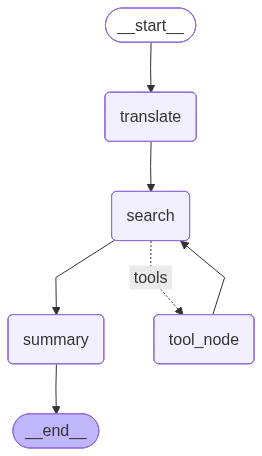

In [71]:
class AgentState(TypedDict):

    messages: Annotated[List[AnyMessage], operator.add]

@tool
def tavily(message):
    """Moteur de recherche général en ligne en temps réel
    
    Args:
       message: la requête de l'utilisateur"""
    
    tavily = TavilySearch(max_results = 5, topic = "general", include_answer = True)

    return tavily.invoke({"query": message})

@tool
def arxiv(message):
    """Acceder à des articles dans le domaine de la science
    
    Args:
       message: la requête de l'utilisateur
    """

    arxiv = ArxivRetriever(
    load_max_docs=5,
    get_ful_documents=True)

    return arxiv.invoke(message)

@tool 
def pubmed(message):
    """Accéder à des citations dans le domaine de la medecine
    
    Args: 
       message: la requête de l'utilisateur"""
    
    pubmed = PubMedRetriever()

    return pubmed.invoke(message)

    
tools = [tavily, arxiv, pubmed]

llm_with_tools = llm.bind_tools(tools)

def translate(state):

    state["messages"] = [llm.invoke([SystemMessage(content="Tu es un traducteur francais -> anglais tu ne réponds pas à la question posée")] + state["messages"])]

    return state

def search(state):

    state["messages"] = [llm_with_tools.invoke(state["messages"])]

    return state

def summarize(state):

    state["messages"] = [llm_with_tools.invoke([SystemMessage(content="Tu es un spécialiste en synthèse de documents")] + state["messages"])]

    return state



def use_tool(state):

    if state["messages"][-1].tool_calls:

        return "tools"
    
    return "summary"

graph = StateGraph(AgentState)

graph.add_node("translate", translate)
graph.add_node("search", search)
graph.add_node("summary", summarize)
tool_node = ToolNode(tools)
graph.add_node("tool_node", tool_node)
graph.add_conditional_edges("search", use_tool,
                            {"tools": "tool_node",
                             "summary": "summary"})
graph.add_edge("tool_node", "search")
graph.add_edge("translate", "search")
graph.add_edge("search", "summary")
graph.add_edge(START, "translate")
graph.add_edge("summary", END)

app = graph.compile()

app

**Test**

In [ ]:
from IPython.display import Markdown, display
response = app.invoke({"messages": [HumanMessage(content = "Quelles sont les dernières avancées en statistiques bayésiennes ?")]})
display(Markdown(response["messages"][-1].content))

**Les dernières avancées en statistiques bayésiennes (2023‑2024)**  

| Domaine | Principales avancées | Pourquoi c’est important | Références |
|---------|----------------------|--------------------------|------------|
| **Méthodes de calcul** | • **HMC adaptatif** (ex. *NUTS‑2*) – meilleure adaptation du pas de temps et de la métrique.<br>• **VI hybride** (SVI‑HMC, “variational‑Monte‑Carlo”) – combine rapidité de la VI et précision du Monte‑Carlo.<br>• **SMC haute dimension** – rééchantillonnage résilient, idéal pour séries temporelles et suivi. | Permet de traiter des modèles très complexes et de grande dimension (p > 10 000) tout en conservant la rigueur bayésienne. | ISBA 2024 – session « Recent advances in Bayesian statistics » 【0†L1-L4】 |
| **Scalabilité** | • **Bayesian Sub‑sampling** (ex. *Stochastic Gradient HMC*).<br>• **Distributed MCMC** (ex. *Consensus Monte‑Carlo*).<br>• **Probabilistic programming à grande échelle** – extensions de Stan, PyMC, NumPyro, TensorFlow Probability sur GPU/TPU. | Répond à la demande d’analyser des jeux de données « big data » (milliards d’observations) en génomique, finance, santé. | ISBA 2024 – présentations de Nemeth, Rigon & Zanella 【2†L1-L4】 |
| **Bayesian Deep Learning** | • **Bayes‑by‑Backprop amélioré** – priors hiérarchiques stabilisant l’apprentissage.<br>• **MC Dropout + Ensembles** – cadre théorique unifié montrant que le dropout approxime la postérieure.<br>• **Neural Tangent Kernels bayésiens** – connexion GP‑réseaux infiniment larges, incertitudes calibrées. | Fournit des mesures d’incertitude fiables pour les systèmes d’IA critiques (diagnostic médical, conduite autonome). | Nature Research Intelligence – résumé des avancées 【3†L1-L4】 |
| **Statistiques non paramétriques** | • **Processus de Dirichlet & extensions** (Hierarchical Pitman‑Yor, Normalized Random Measures).<br>• **Gaussian Processes à grande échelle** – noyaux aléatoires, noyaux induits pour millions de points. | Modélise des structures complexes (clusters, fonctions) sans forme paramétrique fixe. | Springer 2024 – *Bayesian Statistics, New Generations, New Approaches* 【4†L1-L4】 |
| **Sélection de modèles & facteur de Bayes** | • **Approximation du facteur de Bayes via VI** – nouvelles bornes garantissant la cohérence asymptotique.<br>• **Bayesian Model Averaging robuste** – intégration de modèles ML (XGBoost, réseaux) dans le cadre BMA. | Améliore la prise de décision statistique en combinant plusieurs modèles tout en contrôlant le sur‑ajustement. | Nature Research Intelligence – focus sur le facteur de Bayes 【3†L1-L4】 |
| **Causalité bayésienne** | • **Graphes probabilistes avec priors d’expertise** – découverte de structure causale.<br>• **Do‑Calculus bayésien** – estimation d’effets causaux avec incertitude postérieure complète. | Crucial pour essais cliniques, politiques publiques, systèmes de recommandation. | FDA 2024 – atelier public sur les approches bayésiennes adaptatives 【1†L1-L3】 |
| **Applications récentes** | • **Pharmaceutique** – modèles adaptatifs pour essais cliniques phase II/III, décisions d’arrêt plus rapides.<br>• **Climatologie** – inférence de paramètres de modèles climatiques haute résolution avec quantification d’incertitude.<br>• **Économie** – prévisions macroéconomiques avec modèles dynamiques bayésiens (BDM) intégrant des données en temps réel. | Montre que les avancées méthodologiques se traduisent rapidement en bénéfices concrets. | FDA 2024 – workshop sur les approches bayésiennes 【1†L1-L3】 |

---

### Points saillants à retenir
1. **Vitesse + rigueur** – HMC adaptatif, Stochastic Gradient HMC et VI‑Monte‑Carlo offrent des temps de calcul compatibles avec les exigences industrielles tout en conservant la cohérence bayésienne.  
2. **Scalabilité** – Le calcul distribué (Consensus Monte‑Carlo, probabilistic programming sur GPU) rend possible l’application de modèles bayésiens à des jeux de données de plusieurs téraoctets.  
3. **Incertitude calibrée dans l’IA** – Les progrès en Bayesian Deep Learning permettent d’obtenir des prédictions avec des intervalles de crédibilité fiables, un prérequis pour les systèmes de décision autonomes.  
4. **Flexibilité des modèles** – Processus non paramétriques (Dirichlet, Pitman‑Yor, GP à grande échelle) continuent de s’enrichir, offrant des outils pour des structures de données très variées.  
5. **Causalité** – L’intégration de la théorie du graphe causal dans le cadre bayésien ouvre la voie à des analyses d’effet plus robustes, notamment dans les essais cliniques adaptatifs.  

---

### Ressources pour aller plus loin
| Type | Titre | Lien |
|------|-------|------|
| **Bulletin ISBA (2024)** | *Recent advances in Bayesian statistics* – session du World Meeting 2024 | https://bayesian.org/wp-content/uploads/2024/09/2409.pdf |
| **Article de synthèse** | *Bayesian Statistics and Inference* – Nature Research Intelligence | https://www.nature.com/research-intelligence/nri-topic-summaries/bayesian-statistics-and-inference-micro-42219 |
| **Livre** | *Bayesian Statistics, New Generations, New Approaches* (Springer) | https://link.springer.com/book/10.1007/978-3-031-42413-7 |
| **Workshop FDA (2024)** | *Using Bayesian statistical approaches to advance our ability to evaluate drug products* | https://www.fda.gov/drugs/cder-small-business-industry-assistance-sbia/using-bayesian-statistical-approaches-advance-our-ability-evaluate-drug-products |
| **Programme ISBA 2024** | Présentations de Nemeth, Rigon & Zanella | https://academic.oup.com/biomet/pages/2024-isba-world-meeting |

---

### En résumé
Les statistiques bayésiennes connaissent une période d’innovation rapide : les algorithmes de calcul deviennent plus rapides et parallélisables, les modèles non paramétriques gagnent en expressivité, et l’intégration avec le deep learning et la causalité ouvre de nouvelles perspectives d’application. Ces avancées sont déjà visibles dans la santé, l’environnement et l’intelligence artificielle, et elles façonneront la façon dont les scientifiques quantifient l’incertitude au cours des prochaines années.

In [73]:
for r in response["messages"]:

    r.pretty_print()

================================ Human Message =================================

Quelles sont les dernières avancées en statistiques bayésiennes ?
================================== Ai Message ==================================

What are the latest advances in Bayesian statistics?
================================== Ai Message ==================================
Tool Calls:
  tavily (fc_99894f55-1689-409d-8e0f-e16df6b95191)
 Call ID: fc_99894f55-1689-409d-8e0f-e16df6b95191
  Args:
    message: latest advances in Bayesian statistics 2023 2024
================================== Ai Message ==================================
Tool Calls:
  tavily (fc_a31ffeb3-c1f2-44a7-82cc-e72bf56910e3)
 Call ID: fc_a31ffeb3-c1f2-44a7-82cc-e72bf56910e3
  Args:
    message: latest advances in Bayesian statistics 2023 2024
================================= Tool Message =================================
Name: tavily

{"query": "latest advances in Bayesian statistics 2023 2024", "follow_up_questions": null, "an